In [1]:
%pylab --no-import-all inline

import networkx as nx
import os
os.chdir(os.path.abspath('..'))
from tests.test_stencils import HorizontalDiffusionTest

Populating the interactive namespace from numpy and matplotlib


To demonstrate some data dependency analysis features, we will use the Horizontal Diffusion stencil.

Here is the code for reference:

``` python
class HorizontalDiffusion (MultiStageStencil):
    def __init__ (self, domain):
        super ( ).__init__ ( )
        #
        # temporary data fields to share data among the different stages
        #
        self.lap = np.zeros (domain)
        self.fli = np.zeros (domain)
        self.flj = np.zeros (domain)


    def stage_flux_i (self, out_fli, in_lap):
        for p in self.get_interior_points (out_fli,
                                           ghost_cell=[-1,0,-1,0]):
            out_fli[p] = in_lap[p + (1,0,0)] - in_lap[p]


    def stage_flux_j (self, out_flj, in_lap):
        for p in self.get_interior_points (out_flj,
                                           ghost_cell=[-1,0,-1,0]):
            out_flj[p] = in_lap[p + (0,1,0)] - in_lap[p]


    @Stencil.kernel
    def kernel (self, out_data, in_data, in_wgt):
        #
        # Laplace
        #
        for p in self.get_interior_points (self.lap,
                                           ghost_cell=[-1,1,-1,1]):
            self.lap[p] = -4.0 * in_data[p] +  (
                          in_data[p + (-1,0,0)] + in_data[p + (1,0,0)] +
                          in_data[p + (0,-1,0)] + in_data[p + (0,1,0)] )
        #
        # the fluxes are independent, because they depend on 'self.lap'
        #
        self.stage_flux_i (out_fli = self.fli,
                           in_lap  = self.lap)
        self.stage_flux_j (out_flj = self.flj,
                           in_lap  = self.lap)

        for p in self.get_interior_points (out_data):
            #
            # Last stage
            #
            out_data[p] = in_wgt[p] * (
                          self.fli[p + (-1,0,0)] - self.fli[p] +
                          self.flj[p + (0,-1,0)] - self.flj[p] )
```                         

Instantiate the test fixture for the Horizontal Diffusion stencil.
The test fixture already contains all the elements needed to demonstrate to the stencil,
so we don't need to add more boilerplate code here

In [2]:
t = HorizontalDiffusionTest()
t.setUp()
t._run()

Let's get a direct reference to the stencil to simplify the commands a bit

In [3]:
stencil = t.stencil

List the stencil stages:

In [4]:
stencil.stages

[horizontaldiffusion_001_stage_000,
 horizontaldiffusion_001_stage_flux_j_002,
 horizontaldiffusion_001_stage_flux_i_001,
 horizontaldiffusion_001_stage_003]

Plot data dependencies at stencil scope and stage execution dependencies

Suggestion: run this cell until you get decent-looking graphs.
Networkx can generate some weird and intricate node arrangements...

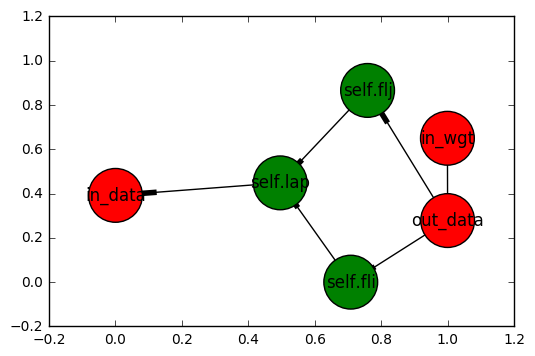

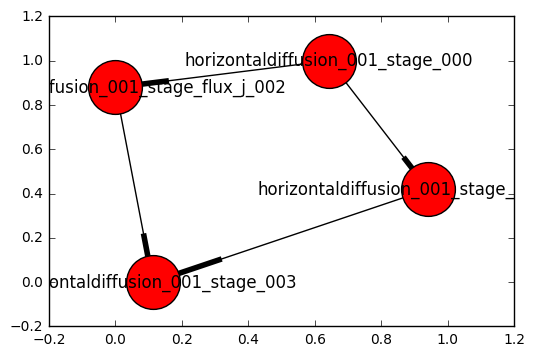

In [6]:
stencil.plot_data_dependency(show_legend=False)
stencil.plot_stage_execution()

We can get a reference to the stencil's data dependency graph to analyze it in more detail

In [7]:
stdd = stencil.get_data_dependency()

Symbols detected at stencil scope

In [8]:
stencil.scope.data_dependency.nodes()

[self.lap, in_wgt, self.flj, out_data, self.fli, in_data]

Print the data dependency connections

In [9]:
stencil.scope.data_dependency.edges()

[(self.lap, in_data),
 (self.flj, self.lap),
 (out_data, in_wgt),
 (out_data, self.fli),
 (out_data, self.flj),
 (self.fli, self.lap)]

Print a list of predecessors of each node starting from the final output data.
In simpler terms, for each node, print the nodes that depend on it (due to the way this graph is constructed).
Keep in mind this is still at stencil scope.

In [10]:
nx.predecessor(stdd,'out_data')

{self.lap: [self.fli, self.flj],
 in_wgt: ['out_data'],
 self.flj: ['out_data'],
 'out_data': [],
 self.fli: ['out_data'],
 in_data: [self.lap]}

For a given node, print the nodes it depends on

In [11]:
stdd.successors('out_data')

[in_wgt, self.fli, self.flj]

Plot data dependencies for each stage

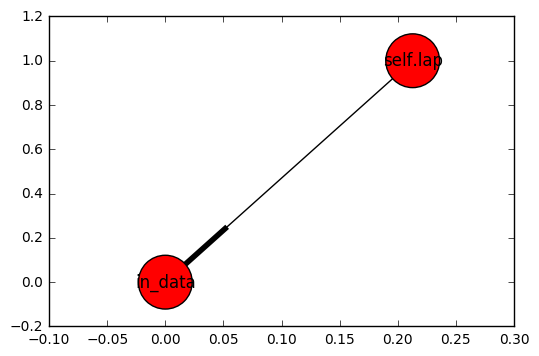

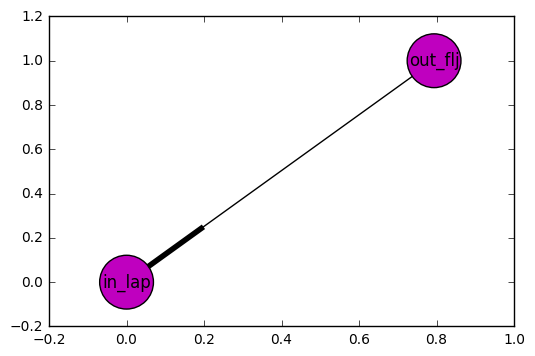

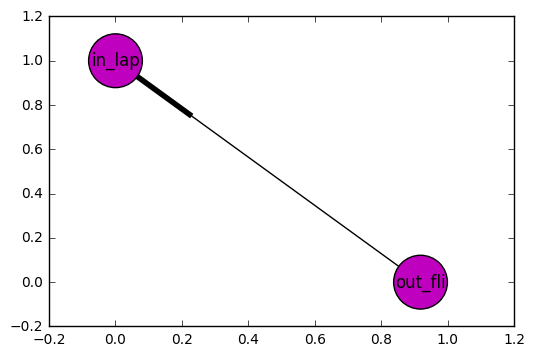

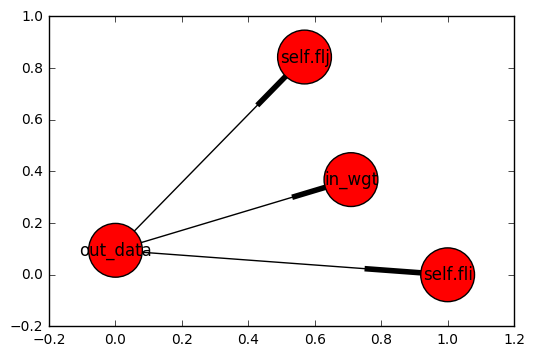

In [12]:
for stg in t.stencil.stages:
    stencil.plot_data_dependency(stg.get_data_dependency(), stg.scope)

Symbol tables (dictionaries) for each stage
Note that the tables contain also the symbols at stencil scope that have been aliased by other symbols in the stage scope!
On the other hand, the aliased symbols are not present in the dependency graph.

In [17]:
for stg in stencil.stages:
    print('Stage: %s' % stg.name)
    print(stg.scope.symbol_table,'\n')

Stage: horizontaldiffusion_003_stage_000
{'self.lap': self.lap, 'in_data': in_data} 

Stage: horizontaldiffusion_003_stage_flux_j_002
{'self.lap': self.lap, 'out_flj': out_flj, 'self.flj': self.flj, 'in_lap': in_lap} 

Stage: horizontaldiffusion_003_stage_flux_i_001
{'self.fli': self.fli, 'out_fli': out_fli, 'self.lap': self.lap, 'in_lap': in_lap} 

Stage: horizontaldiffusion_003_stage_003
{'self.fli': self.fli, 'in_wgt': in_wgt, 'out_data': out_data, 'self.flj': self.flj} 



Values from a symbol table or nodes from a data dependency graph are Symbol objects!

In [18]:
sym_tbl_obj = stencil.stages[0].scope.symbol_table['in_data']
print(type(sym_tbl_obj))

dep_graph_obj = stencil.stages[0].get_data_dependency().nodes()[0]
print(type(dep_graph_obj))

<class 'gridtools.symbol.Symbol'>
<class 'gridtools.symbol.Symbol'>


Symbol objects have a name, a kind and a value.

Show that `in_lap` inside the Flux I stage scope is an alias to the stencil's `self.lap` data field

In [19]:
in_data_symbol = stencil.stages[1].scope.data_dependency.nodes()[1]
print('name:\t',in_data_symbol.name)
print('kind:\t',in_data_symbol.kind)
print('value:\t',in_data_symbol.value)

name:	 in_lap
kind:	 alias
value:	 self.lap


Show that `self.lap` inside the Laplace stage scope is a parameter and the Symbol value is a reference to the Numpy array

In [20]:
out_lap_symbol = stencil.stages[0].scope.data_dependency.nodes()[0]
print('name:\t',out_lap_symbol.name)
print('kind:\t',out_lap_symbol.kind)
print('value:\t',out_lap_symbol.value)

name:	 self.lap
kind:	 param
value:	 [[[  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]
  ..., 
  [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]]

 [[  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]
  [  3.00000000e+01   3.00000000e+01   3.00000000e+01 ...,   3.00000000e+01
     3.00000000e+01   3.00000000e+01]
  [  3.00000000e+01   3.00000000e+01   3.